## Preparing features and Labels

In [ ]:
import tensorflow as tf 
import numpy as np

In [ ]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [ ]:
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end = ' ' )
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [ ]:
dataset = dataset.window(5, shift=1, drop_remainder= True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end = ' ' )
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder= True)
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Lets Split x and y

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder= True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Shuffling The Data

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder= True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size= 10)

for x, y in dataset:
  print(x.numpy(), y.numpy())

[1 2 3 4] [5]
[2 3 4 5] [6]
[4 5 6 7] [8]
[3 4 5 6] [7]
[5 6 7 8] [9]
[0 1 2 3] [4]


Batching The Data

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder= True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size= 10)
dataset = dataset.batch(2).prefetch(1)

for x, y in dataset:
  print('x =', x.numpy())
  print('y =', y.numpy())

x = [[3 4 5 6]
 [5 6 7 8]]
y = [[7]
 [9]]
x = [[2 3 4 5]
 [4 5 6 7]]
y = [[6]
 [8]]
x = [[0 1 2 3]
 [1 2 3 4]]
y = [[4]
 [5]]


In [ ]:
import matplotlib.pyplot as plt

def plot_series(time, series, format = '', start= 0, end= None, label = None):
  plt.plot(time[start:end], series[start:end], format, label= label, )
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)
  if label:
    plt.legend(fontsize = 10)


def trend(time,slope = 0):
  return slope*time

def seasonal_pattern(season_time):
  'an arbitrary pattern'

  return np.where(season_time < 0.4,
                  np.cos(season_time *5 * np.pi),
                  1/ np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  'Repeats the same pattern at each period'

  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365 +1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# creating the series

series = baseline + trend(time, slope) + seasonality(time, period= 365, amplitude= amplitude)
series += white_noise(time, noise_level, seed= 42)


split_time = 1000
train_time = time[:split_time]
train_x = series[:split_time]

valid_time = time[split_time:]
valid_x = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
import tensorflow as tf 

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch((window_size + 1 )))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    

## Single Layer NN

spliting the data

In [ ]:
dataset = windowed_dataset(train_x, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(1, input_shape = [window_size])
])

In [ ]:
model.compile(loss= 'mse', optimizer = tf.keras.optimizers.SGD(1e-6,momentum= 0.9))

In [ ]:
model.fit(dataset, epochs=100, verbose=0)

In [ ]:
print(f'Layer Weights {model.get_weights()}')

Layer Weights [array([[-0.04412054],
       [-0.02406365],
       [-0.00929546],
       [ 0.07657726],
       [ 0.0380566 ],
       [-0.08919007],
       [-0.04461984],
       [ 0.03192173],
       [ 0.01984142],
       [-0.02384745],
       [-0.06327288],
       [ 0.09343382],
       [-0.10161054],
       [-0.05947468],
       [ 0.10366404],
       [ 0.18306117],
       [ 0.09972944],
       [ 0.2084067 ],
       [ 0.2402911 ],
       [ 0.36563236]], dtype=float32), array([0.03100152], dtype=float32)]


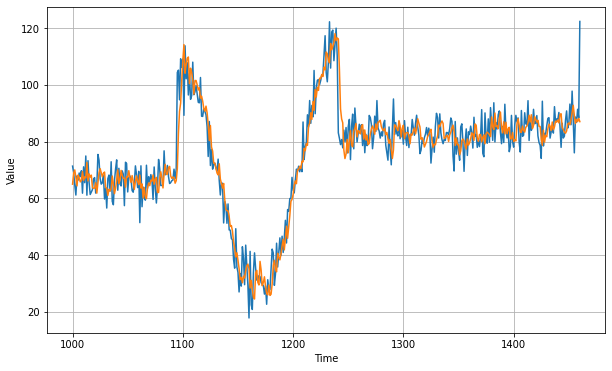

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(valid_x, results).numpy()

5.032158

## Using DNN

In [ ]:
from tensorflow import keras as tk
from tensorflow.keras import layers as tkl
from tensorflow.keras.layers import Dense as tkld  

In [ ]:
model = tk.models.Sequential([
                              tkld(10, input_shape = [window_size], activation= 'relu'),
                              tkld(10, activation='relu'),
                              tkld(1)
])

# callabacks
lr_schedule = tk.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = tk.optimizers.SGD(lr= 1e-8, momentum= 0.9)


model.compile(loss= 'mse', optimizer= optimizer, metrics= ['acc'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(dataset, epochs= 100, verbose= 0, callbacks= [lr_schedule])

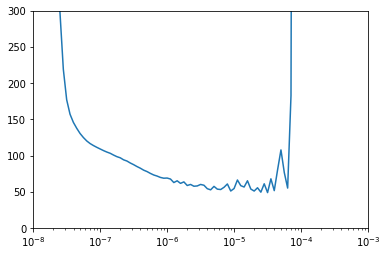

In [ ]:
lrs = 1e-8 * (10**(np.arange(100) /20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3,0,300])
plt.show()

best lr is between 10-6 to 10-5
so we can try with 7e-6

In [ ]:
optimizer = tk.optimizers.SGD(lr= 7e-6, momentum= 0.9)
model.compile(loss= 'mse', optimizer= optimizer)

In [ ]:
history = model.fit(dataset, epochs= 600)

Epoch 1/600
31/31 [==============================] - 0s 2ms/step - loss: 861.5708
Epoch 2/600
31/31 [==============================] - 0s 2ms/step - loss: 98.5764
Epoch 3/600
31/31 [==============================] - 0s 2ms/step - loss: 70.3487
Epoch 4/600
31/31 [==============================] - 0s 2ms/step - loss: 57.5210
Epoch 5/600
31/31 [==============================] - 0s 2ms/step - loss: 58.1819
Epoch 6/600
31/31 [==============================] - 0s 2ms/step - loss: 76.9572
Epoch 7/600
31/31 [==============================] - 0s 2ms/step - loss: 70.5654
Epoch 8/600
31/31 [==============================] - 0s 2ms/step - loss: 58.5759
Epoch 9/600
31/31 [==============================] - 0s 3ms/step - loss: 51.8976
Epoch 10/600
31/31 [==============================] - 0s 2ms/step - loss: 52.5375
Epoch 11/600
31/31 [==============================] - 0s 2ms/step - loss: 56.1125
Epoch 12/600
31/31 [==============================] - 0s 2ms/step - loss: 54.0578
Epoch 13/600
31/31 [====

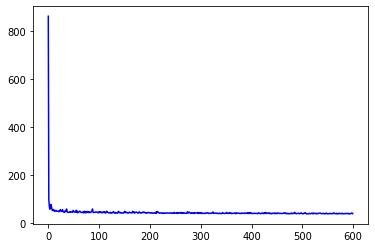

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[56.11250305175781, 54.05778121948242, 48.11008834838867, 51.383934020996094, 50.200347900390625, 52.14186096191406, 50.05714797973633, 48.53710174560547, 48.40792465209961, 48.85216522216797, 47.92565155029297, 46.188899993896484, 51.748172760009766, 50.32500457763672, 55.221946716308594, 49.11213684082031, 49.701499938964844, 47.51566696166992, 55.038360595703125, 46.937049865722656, 46.03089141845703, 44.7254638671875, 47.66972732543945, 45.67637634277344, 51.54424285888672, 49.95956802368164, 57.9149284362793, 46.173858642578125, 44.69163513183594, 43.426490783691406, 43.88068389892578, 45.04726028442383, 44.487709045410156, 47.20267868041992, 44.4649543762207, 45.54130172729492, 46.203460693359375, 46.475303649902344, 44.347206115722656, 51.615203857421875, 46.9430046081543, 46.559513092041016, 44.88941192626953, 45.267921447753906, 45.01605224609375, 52.65444564819336, 44.29737854003906, 48.60909652709961, 42.22730255126953, 43.75070571899414, 44.83063888549805, 47.94771194458008

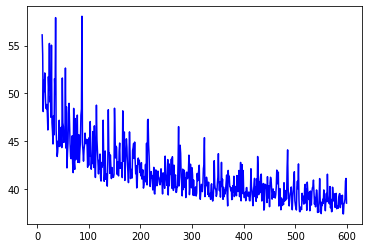

In [ ]:
# plot all but the first 10

loss = history.history['loss']
epochs = range(10,len( loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()


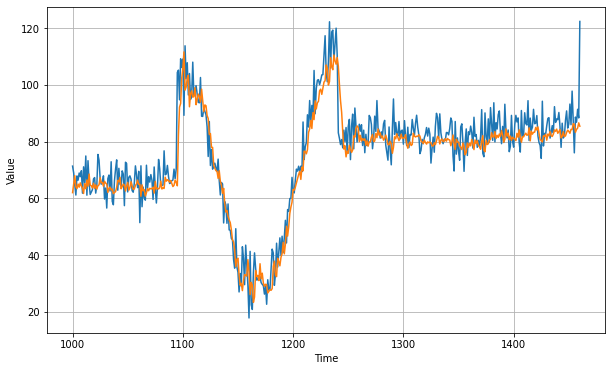

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [ ]:
tk.metrics.mean_absolute_error(valid_x, results).numpy()

5.164593

## Using RNN

In [ ]:
model = tk.models.Sequential([
                              tkl.SimpleRNN(20, return_sequences= True, input_shape = [None, 1]),
                              tkl.SimpleRNN(20),
                              tkld(1)
])

adding lambda layer for arbitrary computation

In [ ]:
# as our dataset is 2 dim but rnn need 3 dim we can expand dim using Lambda layer

model = tk.models.Sequential([
                              tkl.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
                              tkl.SimpleRNN(20, return_sequences= True, input_shape = [None, 1]),
                              tkl.SimpleRNN(20),
                              tkld(1),
                              tkl.Lambda(lambda x: x*100.0)
])

# as default activation function of rnn is tanh, our output range from -1,1.. so we are scaling to normal sequence like 30,40 as time series are like that

In [ ]:
lr_schedule = tk.callbacks.LearningRateScheduler(lambda epoch: 1e-8* 10**(epoch /20))

optimizer = tk.optimizers.SGD(lr = 1e-6, momentum= 0.9)

In [ ]:
model.compile(loss = tk.losses.Huber(), optimizer= optimizer, metrics= ['mae'])

In [12]:
history = model.fit(dataset, epochs= 500)

Epoch 1/500
31/31 [==============================] - 0s 7ms/step - loss: 12.2418 - mae: 12.7281
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 8.8774 - mae: 9.3563
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 8.4375 - mae: 8.9230
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 8.0511 - mae: 8.5383
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 7.9809 - mae: 8.4646
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 7.7359 - mae: 8.2197
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 7.9848 - mae: 8.4707
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 7.5873 - mae: 8.0754
Epoch 9/500
31/31 [==============================] - 0s 7ms/step - loss: 7.3715 - mae: 7.8539
Epoch 10/500
31/31 [==============================] - 0s 7ms/step - loss: 7.1599 - mae: 7.6405
Epoch 11/500
31/31 [==============================] - 0s 

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-3,0,300])
plt.show()

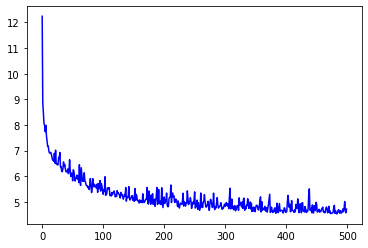

In [16]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[7.171518802642822, 6.974542617797852, 6.904532432556152, 6.902678966522217, 6.930115222930908, 6.861112117767334, 6.7458319664001465, 6.6303205490112305, 6.614772796630859, 6.581850051879883, 6.891003131866455, 6.50710916519165, 7.0144243240356445, 6.4785566329956055, 6.478700637817383, 6.444699764251709, 6.437698841094971, 6.73377799987793, 6.69128942489624, 6.925524711608887, 6.36585807800293, 6.374541282653809, 6.1878228187561035, 6.173360347747803, 6.289543628692627, 6.554038047790527, 6.376225471496582, 6.45416784286499, 6.285147666931152, 6.17677116394043, 6.164229393005371, 6.177621841430664, 6.281689167022705, 6.096940040588379, 6.224908351898193, 6.642405033111572, 6.198675632476807, 5.990453720092773, 6.11769962310791, 6.109935760498047, 5.818661212921143, 6.246410846710205, 6.196645259857178, 5.997371673583984, 5.8105621337890625, 5.901960372924805, 5.947932243347168, 6.042519569396973, 5.891361713409424, 6.015178680419922, 5.750208854675293, 6.443569660186768, 5.8137059211

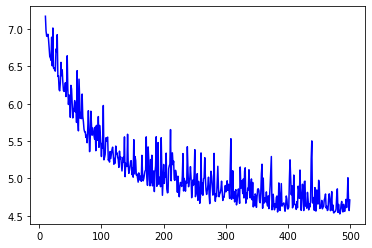

In [17]:
loss = history.history['loss']
epochs = range(10,len( loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

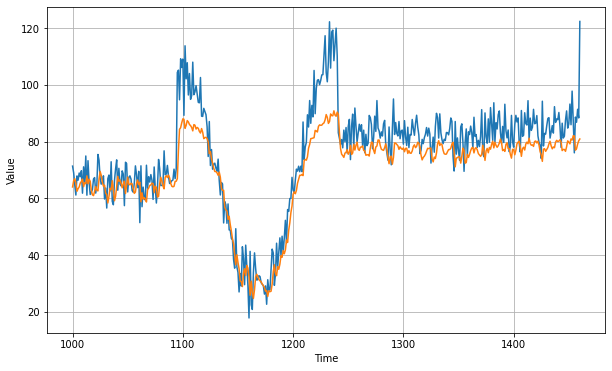

In [18]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [19]:
tk.metrics.mean_absolute_error(valid_x, results).numpy()

7.1623993

<Figure size 432x288 with 0 Axes>

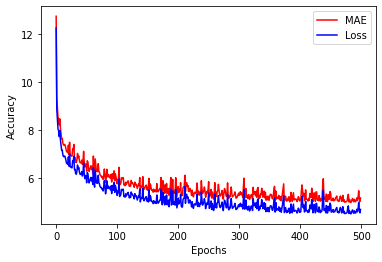

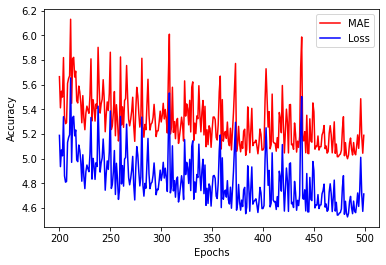

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))


plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]



plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', "Loss"])

plt.figure()


## LSTM

In [ ]:
model = tk.models.Sequential([
                              tkl.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
                              tkl.Bidirectional(tkl.LSTM(32)),
                              tkld(1),
                              tkl.Lambda(lambda x: x*100.0)
])


In [ ]:
lr_schedule = tk.callbacks.LearningRateScheduler(lambda epoch: 1e-8* 10**(epoch /20))

optimizer = tk.optimizers.SGD(lr = 1e-6, momentum= 0.9)

In [ ]:
model.compile(loss = 'mse', optimizer= optimizer, metrics= ['mae'])

In [ ]:
history = model.fit(dataset, epochs = 400, verbose=0)

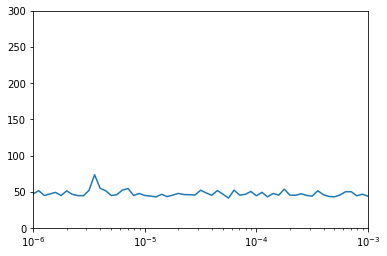

In [35]:
lrs = 1e-6 * (10**(np.arange(400) /20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-6, 1e-3,0,300])
plt.show()

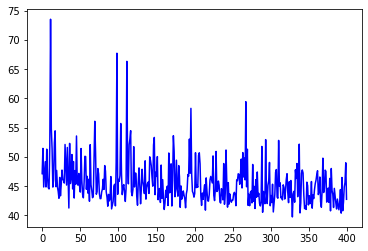

In [36]:
epochs = range(len(loss))
plt.plot(epochs,history.history['loss']
epochs pochs, loss, 'b', label = 'Training Loss')
plt.show()

[51.92519760131836, 73.51217651367188, 54.78607177734375, 51.352073669433594, 44.81206130981445, 46.067726135253906, 52.38029861450195, 54.430091857910156, 44.8849983215332, 47.653717041015625, 44.84850311279297, 44.070682525634766, 42.899131774902344, 46.46350860595703, 43.31647872924805, 45.30668258666992, 47.72359848022461, 46.161720275878906, 45.91831970214844, 45.50178909301758, 52.09593963623047, 48.41594696044922, 45.16025161743164, 51.5839729309082, 46.738487243652344, 41.235565185546875, 52.283599853515625, 45.41584777832031, 46.42765808105469, 50.37913131713867, 44.49065017700195, 49.18223571777344, 42.93925094604492, 47.63422393798828, 45.327171325683594, 53.549224853515625, 45.38694381713867, 45.13987731933594, 47.14455032348633, 44.989051818847656, 43.958953857421875, 51.40729904174805, 45.93334197998047, 43.59341812133789, 42.97746276855469, 45.669830322265625, 50.07570266723633, 50.02524948120117, 44.429222106933594, 46.651241302490234, 43.78269577026367, 46.146072387695

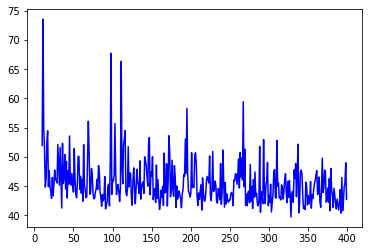

In [37]:
loss = history.history['loss']
epochs = range(10,len( loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

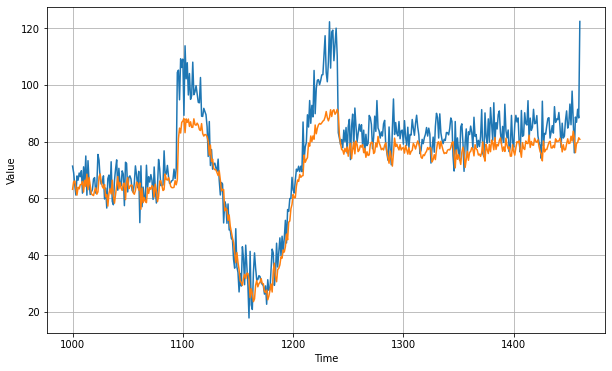

In [38]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [39]:
tk.metrics.mean_absolute_error(valid_x, results).numpy()

7.0908237

Using two layer lstm

In [ ]:
model = tk.models.Sequential([
                              tkl.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
                              tkl.Bidirectional(tkl.LSTM(32, return_sequences= True)),
                              tkl.Bidirectional(tkl.LSTM(32)),
                              tkld(1),
                              tkl.Lambda(lambda x: x*100.0)
])


In [ ]:
lr_schedule = tk.callbacks.LearningRateScheduler(lambda epoch: 1e-8* 10**(epoch /20))

optimizer = tk.optimizers.SGD(lr = 1e-6, momentum= 0.9)

In [ ]:
model.compile(loss = 'mse', optimizer= optimizer, metrics= ['mae'])

In [ ]:
history = model.fit(dataset, epochs = 400, verbose=0)

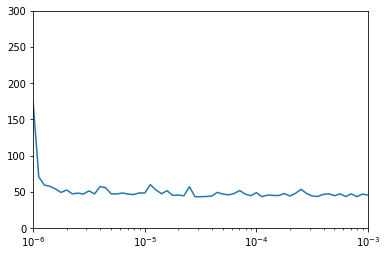

In [44]:
lrs = 1e-6 * (10**(np.arange(400) /20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-6, 1e-3,0,300])
plt.show()

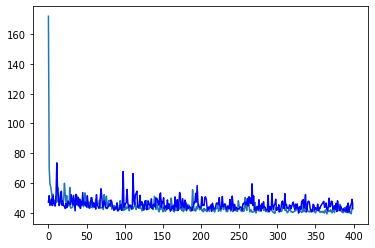

In [47]:
epochs = range(len(loss))
plt.plot(epochs,history.history['loss'])
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[51.20240020751953, 47.06473922729492, 57.253936767578125, 55.366390228271484, 46.910316467285156, 46.97063064575195, 48.31782913208008, 46.74918746948242, 46.159759521484375, 48.41786193847656, 48.189048767089844, 59.7657356262207, 52.474464416503906, 47.29880905151367, 51.44731903076172, 45.04938888549805, 45.40399932861328, 44.457801818847656, 56.98948669433594, 43.12303161621094, 43.183292388916016, 43.43663787841797, 44.0833740234375, 49.1763801574707, 46.765384674072266, 45.69929122924805, 47.52816390991211, 51.680030822753906, 46.72068405151367, 44.6005744934082, 48.73772430419922, 43.292930603027344, 45.388458251953125, 44.93320846557617, 44.83938980102539, 47.53281021118164, 44.0651969909668, 47.82554626464844, 53.327999114990234, 47.60044479370117, 44.214324951171875, 43.47848892211914, 46.41277313232422, 47.19132614135742, 44.55621337890625, 47.02130889892578, 43.45149230957031, 47.02788543701172, 43.250144958496094, 46.79173278808594, 45.44086837768555, 44.89551544189453, 4

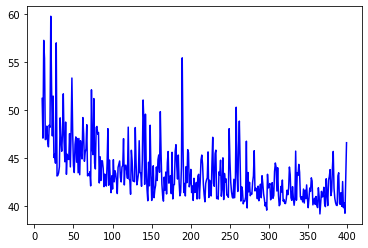

In [48]:
loss = history.history['loss']
epochs = range(10,len( loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

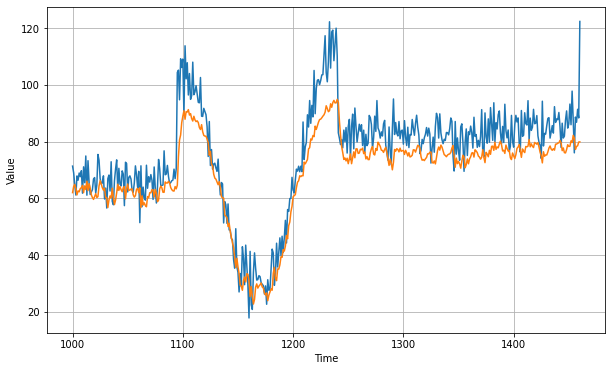

In [49]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [50]:
tk.metrics.mean_absolute_error(valid_x, results).numpy()

7.583091

## CNN

In [ ]:
def plot_series(time, series, format = '', start= 0, end= None, label = None):
  plt.plot(time[start:end], series[start:end], format, label= label, )
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)
  if label:
    plt.legend(fontsize = 10)


def trend(time,slope = 0):
  return slope*time

def seasonal_pattern(season_time):
  'an arbitrary pattern'

  return np.where(season_time < 0.4,
                  np.cos(season_time *5 * np.pi),
                  1/ np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  'Repeats the same pattern at each period'

  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365 +1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# creating the series

series = baseline + trend(time, slope) + seasonality(time, period= 365, amplitude= amplitude)
series += white_noise(time, noise_level, seed= 42)


split_time = 1000
train_time = time[:split_time]
train_x = series[:split_time]

valid_time = time[split_time:]
valid_x = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
import tensorflow as tf 

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    series = tf.expand_dims(series, axis = -1)
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch((window_size + 1 )))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    

In [ ]:
dataset = windowed_dataset(train_x, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tk.models.Sequential([
                              tkl.Conv1D(filters= 32, kernel_size= 5, strides= 1, padding= "causal", activation= 'relu', input_shape = [None,1]),
                              tkl.Bidirectional(tkl.LSTM(32, return_sequences= True)),
                              tkl.Bidirectional(tkl.LSTM(32, return_sequences=True)),
                              tkld(1),
                              tkl.Lambda(lambda x: x*200.0)
])


In [ ]:
model.compile(loss = 'mse', optimizer= optimizer, metrics= ['mae'])

In [69]:
history = model.fit(dataset, epochs = 400)

Epoch 1/400
31/31 [==============================] - 1s 27ms/step - loss: 1197.2581 - mae: 24.0387
Epoch 2/400
31/31 [==============================] - 1s 26ms/step - loss: 180.0412 - mae: 10.4400
Epoch 3/400
31/31 [==============================] - 1s 26ms/step - loss: 264.1078 - mae: 12.9621
Epoch 4/400
31/31 [==============================] - 1s 27ms/step - loss: 234.1710 - mae: 11.9968
Epoch 5/400
31/31 [==============================] - 1s 27ms/step - loss: 200.9144 - mae: 11.1217
Epoch 6/400
31/31 [==============================] - 1s 26ms/step - loss: 183.6584 - mae: 10.4815
Epoch 7/400
31/31 [==============================] - 1s 26ms/step - loss: 180.6602 - mae: 10.5250
Epoch 8/400
31/31 [==============================] - 1s 26ms/step - loss: 170.5509 - mae: 10.0759
Epoch 9/400
31/31 [==============================] - 1s 27ms/step - loss: 161.2162 - mae: 9.7775
Epoch 10/400
31/31 [==============================] - 1s 26ms/step - loss: 154.5153 - mae: 9.5744
Epoch 11/400
31/31 [

Its Important to find the best batch size for my data.. as peak go further we can make batch size bigger..


In [ ]:
lr_schedule = tk.callbacks.LearningRateScheduler(lambda epoch: 1e-8* 10**(epoch /20))

optimizer = tk.optimizers.SGD(lr = 1e-6, momentum= 0.9)

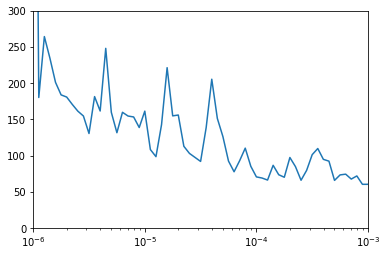

In [71]:
lrs = 1e-6 * (10**(np.arange(400) /20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-6, 1e-3,0,300])
plt.show()

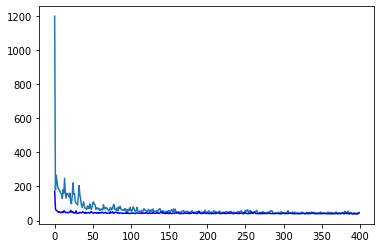

In [73]:
epochs = range(len(loss))
plt.plot(epochs,history.history['loss'])
plt.plot( epochs, loss, 'b', label = 'Training Loss')
plt.show()

[130.3634490966797, 181.30368041992188, 161.41465759277344, 247.85333251953125, 159.62274169921875, 131.46946716308594, 159.6365966796875, 154.47789001464844, 153.19602966308594, 138.63125610351562, 161.23983764648438, 108.21646881103516, 98.42875671386719, 142.579833984375, 221.204833984375, 154.71119689941406, 155.86004638671875, 112.72492218017578, 102.92597198486328, 97.30109405517578, 91.85174560546875, 138.6610565185547, 205.27886962890625, 151.1970977783203, 126.06372833251953, 92.32495880126953, 77.61141204833984, 92.90269470214844, 110.17644500732422, 85.0934066772461, 70.51687622070312, 68.96408081054688, 66.15103912353516, 86.47962951660156, 73.5030517578125, 70.02053833007812, 97.26458740234375, 84.71007537841797, 65.89277648925781, 79.49982452392578, 101.18999481201172, 109.66720581054688, 94.7164077758789, 92.23263549804688, 65.68681335449219, 73.25948333740234, 74.27620697021484, 67.49983215332031, 71.81549835205078, 60.26808547973633, 60.27308654785156, 69.2636032104492

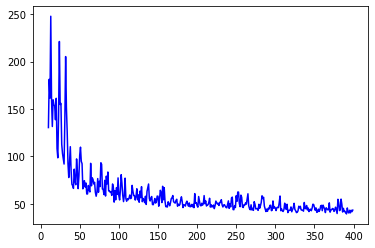

In [74]:
loss = history.history['loss']
epochs = range(10,len( loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [76]:
tk.metrics.mean_absolute_error(valid_x, results).numpy()

7.583091

In [79]:
 !wget --no-check-certificate \
  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \

--2020-06-10 16:26:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-06-10 16:26:27 (99.9 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [ ]:
import pandas as pd


In [ ]:
s = pd.read_csv('Sunspots.csv')

In [ ]:
s.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
s = s.drop(columns= ['Unnamed: 0'])

In [83]:
s.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [ ]:
sunspot = s

In [85]:
sunspot.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


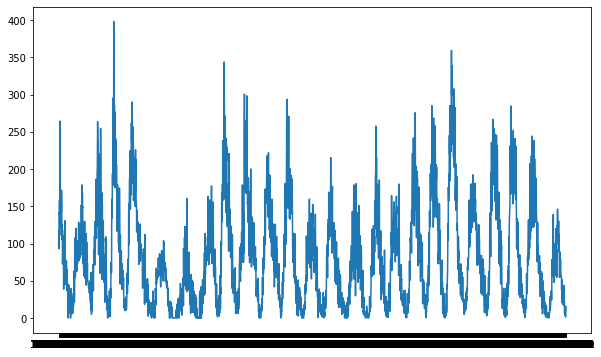

In [87]:
plt.figure(figsize=(10,6))

plt.plot(sunspot['Date'], sunspot['Monthly Mean Total Sunspot Number'])
plt.show()

In [88]:
sunspot.head() 

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [ ]:
sunspot.reset_index(inplace= True)

In [90]:
sunspot.head()

,index,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
time = sunspot['index'].values
series = sunspot['Monthly Mean Total Sunspot Number'].values

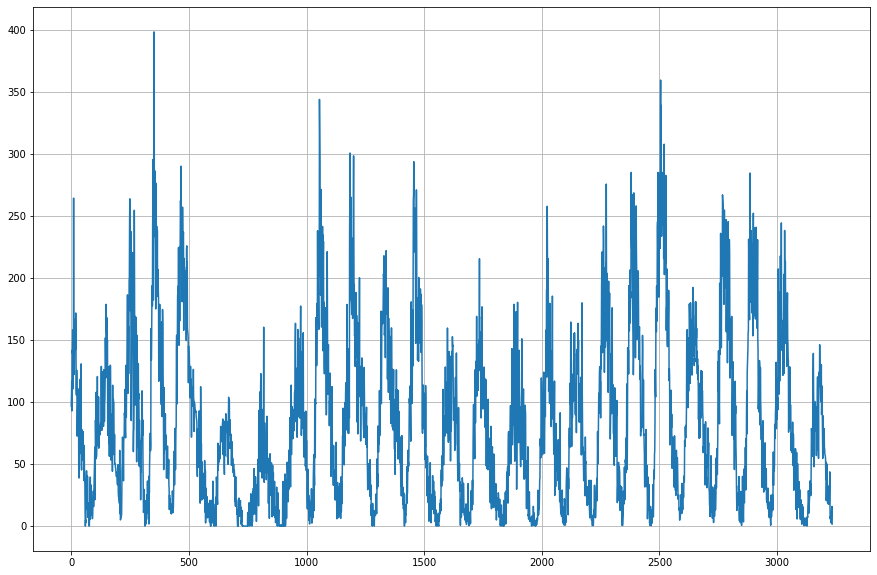

In [118]:
plt.figure(figsize=(15,10))
plt.plot(time, series)
plt.grid()
plt.show()

In [ ]:
split_time = 3000
train_time = time[:split_time]
train_x = series[:split_time]

valid_time = time[split_time:]
valid_x = series[split_time:]


# as our seasonality is 11 years we have make longer window_size
# but it get worse, so we can make it before
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch((window_size + 1 )))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
    

In [ ]:
dataset = windowed_dataset(train_x, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tk.models.Sequential([
                              tkld(20, input_shape = [window_size], activation= 'relu'),
                              tkld(10, activation= 'relu'),
                              tkld(1)
])

In [ ]:
model.compile(loss= 'mse', optimizer= tk.optimizers.SGD(lr= 1e-7, momentum = 0.9))

In [152]:
history = model.fit(dataset, epochs = 500, verbose=1)

Epoch 1/500
92/92 [==============================] - 0s 5ms/step - loss: 2028.1033
Epoch 2/500
92/92 [==============================] - 0s 5ms/step - loss: 992.4014
Epoch 3/500
92/92 [==============================] - 0s 5ms/step - loss: 909.7904
Epoch 4/500
92/92 [==============================] - 0s 5ms/step - loss: 857.7006
Epoch 5/500
92/92 [==============================] - 0s 5ms/step - loss: 843.2865
Epoch 6/500
92/92 [==============================] - 0s 5ms/step - loss: 802.3354
Epoch 7/500
92/92 [==============================] - 0s 5ms/step - loss: 766.5895
Epoch 8/500
92/92 [==============================] - 0s 5ms/step - loss: 751.6300
Epoch 9/500
92/92 [==============================] - 0s 5ms/step - loss: 733.1392
Epoch 10/500
92/92 [==============================] - 0s 5ms/step - loss: 722.9578
Epoch 11/500
92/92 [==============================] - 0s 5ms/step - loss: 716.3525
Epoch 12/500
92/92 [==============================] - 0s 5ms/step - loss: 707.7493
Epoch 13/500

[716.3525390625, 707.7493286132812, 693.9873657226562, 699.3236694335938, 688.8239135742188, 679.9376831054688, 680.7075805664062, 672.2809448242188, 669.0473022460938, 663.8084716796875, 662.7036743164062, 661.4068603515625, 655.0924072265625, 652.9652099609375, 649.0964965820312, 641.1432495117188, 647.0350952148438, 637.5878295898438, 640.9606323242188, 642.263916015625, 639.16259765625, 635.0963745117188, 632.0007934570312, 628.57177734375, 635.8353881835938, 623.0758666992188, 627.69189453125, 625.5867309570312, 622.3388671875, 623.697509765625, 622.5616455078125, 617.0347290039062, 617.7274780273438, 619.01123046875, 617.5797729492188, 615.6061401367188, 618.6250610351562, 611.0330200195312, 610.8748168945312, 611.626220703125, 607.9510498046875, 607.7776489257812, 607.356689453125, 607.7718505859375, 607.7454833984375, 608.5247192382812, 604.303466796875, 601.5193481445312, 604.006103515625, 602.7272338867188, 605.2748413085938, 602.9638671875, 608.0150146484375, 606.90570068359

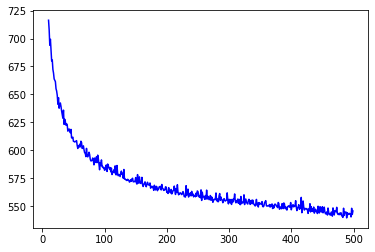

In [156]:
loss = history.history['loss']
epochs = range(10,len( loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

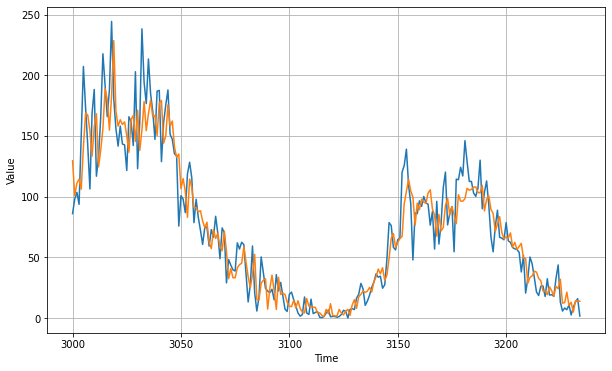

In [157]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0,0]

plt.figure(figsize =(10,6) )

plot_series(valid_time, valid_x)
plot_series(valid_time, results)

In [158]:
tk.metrics.mean_absolute_error(valid_x, results).numpy()

14.357874